In [52]:
from dotenv import load_dotenv
import helper

# Loading data from the enviroment variable
load_dotenv()

True

In [53]:
from anthropic import Anthropic


# Grabs API key from env

client = Anthropic()
model_name = "claude-sonnet-4-6"

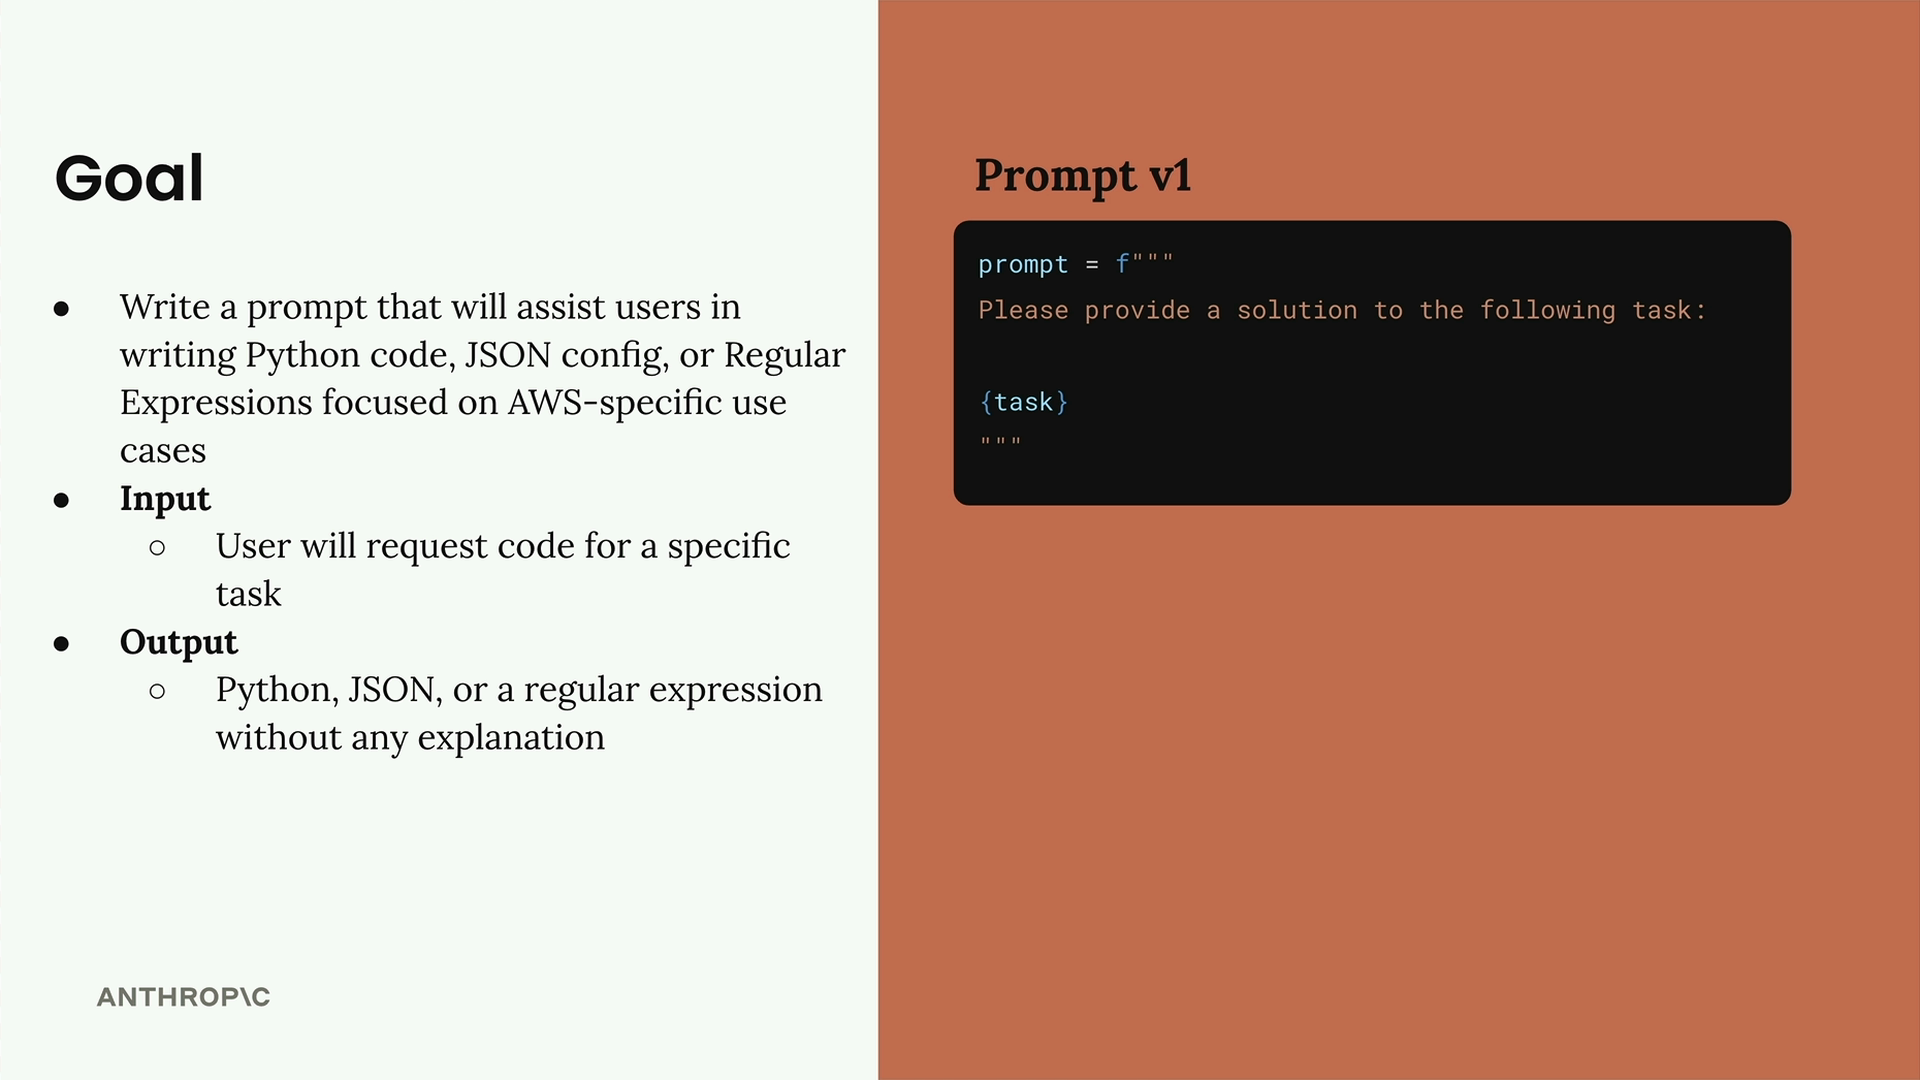

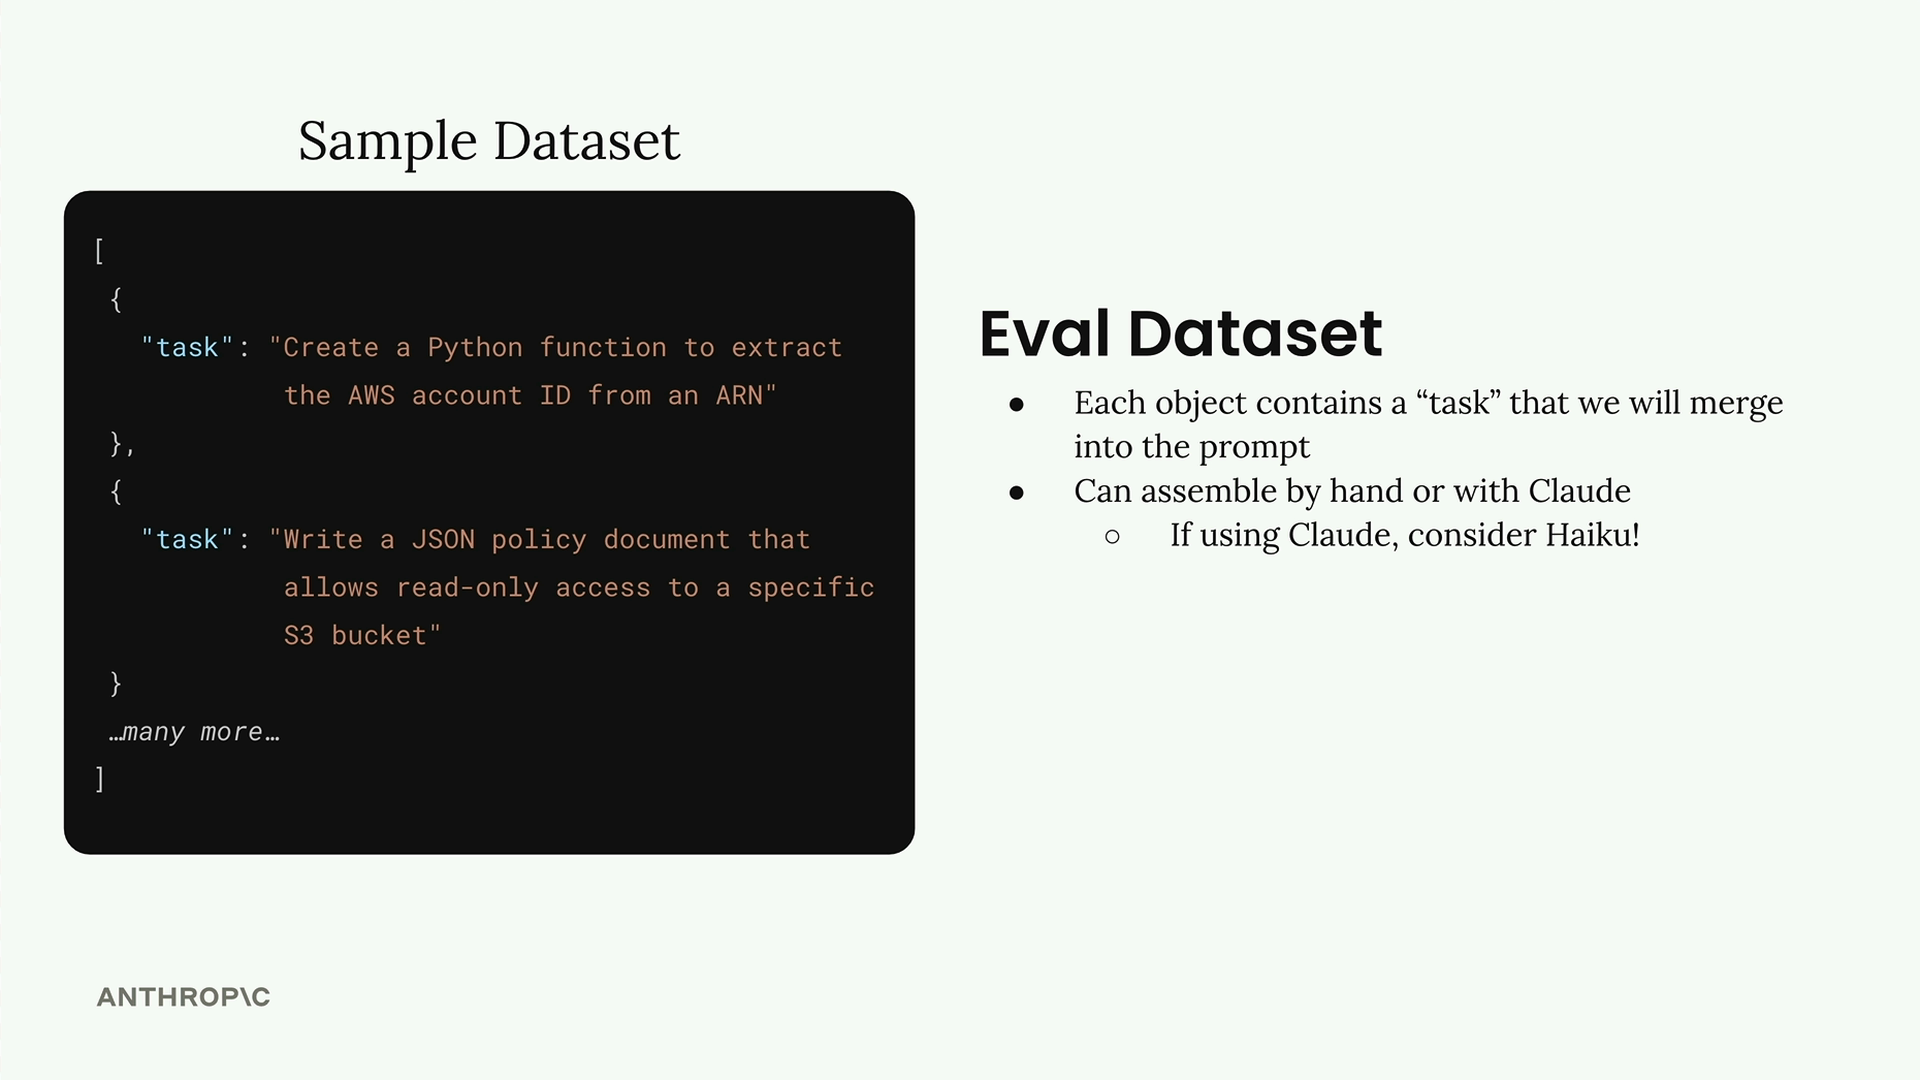

In [54]:
import json

def generate_dataset():
    messages = []
    helper.add_user_message(
        messages=messages,
        content="""Generate an evaluation dataset for a prompt evaluation. 
The dataset will be used to evaluate prompts that generate Python, JSON, or Regex 
specifically for AWS-related tasks. Generate 3 tasks that require Python, JSON, or 
a Regex to complete. Focus on tasks that can be solved by a single Python function, 
a single JSON object, or a regular expression. Focus on tasks that do not require 
writing much code."""
    )

    dataset_schema = {
        "type": "object",
        "properties": {
            "tasks": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "task": {"type": "string"},
                        "format": {"type": "string", "enum": ["Python", "JSON", "RegEx"]}
                    },
                    "required": ["task", "format"],
                    "additionalProperties": False
                }
            }
        },
        "required": ["tasks"],
        "additionalProperties": False
    }

    response = client.messages.create(
        model=model_name,
        max_tokens=1024,
        messages=messages,
        output_config={
            "format": {
                "type": "json_schema",
                "schema": dataset_schema
            }
        }
    )

    parsed = json.loads(response.content[0].text)
    return parsed["tasks"]  # returns a clean list of task dicts


dataset = generate_dataset()

dataset

[{'task': 'Write a Python function that takes an S3 bucket name and a prefix string as arguments, then uses boto3 to list all object keys in that bucket matching the given prefix and returns them as a list of strings.',
  'format': 'Python'},
 {'task': "Write a JSON object representing an IAM policy that allows a user to only read objects from (s3:GetObject) and list contents of (s3:ListBucket) a specific S3 bucket named 'my-company-data'.",
  'format': 'JSON'},
 {'task': 'Write a regular expression that matches a valid Amazon Resource Name (ARN) in the format arn:partition:service:region:account-id:resource, where each segment is separated by a colon and none of the segments are empty.',
  'format': 'RegEx'}]

In [55]:
with open("dataset.json", "w") as f:
    json.dump(dataset, f, indent=2)

### Eval Pipeline Helper Functions

In [56]:
# Model Grader
def grade_by_model(test_case, output):
    eval_prompt = f"""
You are an expert AWS code reviewer. Your task is to evaluate the following AI-generated solution.

Original Task:
<task>
{test_case["task"]}
</task>

Solution to Evaluate:
<solution>
{output}
</solution>

Evaluate the solution on its correctness, quality, and relevance to the task.
Keep your response concise and direct.
"""

    grade_schema = {
        "type": "object",
        "properties": {
            "strengths": {"type": "array", "items": {"type": "string"}},
            "weaknesses": {"type": "array", "items": {"type": "string"}},
            "reasoning": {"type": "string"},
            "score": {"type": "integer"},
        },
        "required": ["strengths", "weaknesses", "reasoning", "score"],
        "additionalProperties": False,
    }

    messages = []
    helper.add_user_message(messages, eval_prompt)

    response = client.messages.create(
        model=model_name,
        max_tokens=1024,
        messages=messages,
        output_config={"format": {"type": "json_schema", "schema": grade_schema}},
    )

    return json.loads(response.content[0].text)

In [66]:
# Functions to validate the output structure
# Code grader
import re
import ast


def validate_json(text):
    try:
        json.loads(text.strip())
        return 10
    except json.JSONDecodeError:
        print("JSON failed")
        return 0


def validate_python(text):
    try:
        ast.parse(text.strip())
        return 10
    except SyntaxError:
        print("Python failed")
        return 0


def validate_regex(text):
    try:
        re.compile(text.strip())
        return 10
    except re.error:
        print("Regex failed")
        return 0


def grade_syntax(response, test_case):
    format = test_case["format"]
    format = str(format).lower()
    if format == "json":
        return validate_json(response)
    elif format == "python":
        return validate_python(response)
    else:
        return validate_regex(response)


In [58]:
def run_prompt(test_case):
    prompt = f"""
Please solve the following task:
<task>
{test_case["task"]}
</task>

* Respond only with raw Python, JSON, or a plain Regex
* Do not add any comments, commentary, explanation, or markdown formatting
* Do not wrap your answer in code blocks
"""
    messages = []
    helper.add_user_message(messages, prompt)

    response = client.messages.create(
        model=model_name,
        max_tokens=1024,
        messages=messages,
    )

    return response.content[0].text.strip()

In [59]:
def run_test_case(test_case):
    """Calls run_prompt, then grades the result"""
    output = run_prompt(test_case)

    model_grade = grade_by_model(test_case=test_case, output=output)
    model_score = model_grade["score"]
    reasoning = model_grade["reasoning"]

    syntax_score = grade_syntax(output, test_case)

    score = (model_score+syntax_score)/2

    return {
        "output": output,
        "test_case": test_case,
        "score": score,
        "reasoning": reasoning,
    }

In [60]:
def run_eval(dataset):
    """Loads the dataset and calls run_test_case with each case"""
    results = []
    
    for test_case in dataset:
        result = run_test_case(test_case)
        results.append(result)
    
    return results

### Run Pipeline

In [67]:
with open("dataset.json", "r") as f:
    dataset = json.load(f)

results = run_eval(dataset=dataset)

In [ ]:
print(json.dumps(results,indent=2))

In [68]:
# Iterate over results
for result in results:
    print(result["test_case"]["task"])
    print(result["test_case"]["format"])
    print(result["output"])
    print(result["score"])
    print(result["reasoning"])
    print("---")


Write a Python function that takes an S3 bucket name and a prefix string as arguments, then uses boto3 to list all object keys in that bucket matching the given prefix and returns them as a list of strings.
Python
import boto3

def list_s3_objects(bucket_name, prefix):
    s3_client = boto3.client('s3')
    keys = []
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                keys.append(obj['Key'])
    return keys
47.5
The solution correctly and efficiently solves the task using best practices for listing S3 objects with boto3. It uses list_objects_v2 with proper pagination, handles the optional 'Contents' key, and returns the expected list of key strings. The main shortcomings are the lack of error handling and limited configurability, but these are minor for a basic utility function. Overall it is a high-quali

In [63]:
# Average score

avg = [result["score"] for result in results]

sum(avg)/len(avg)

43.5

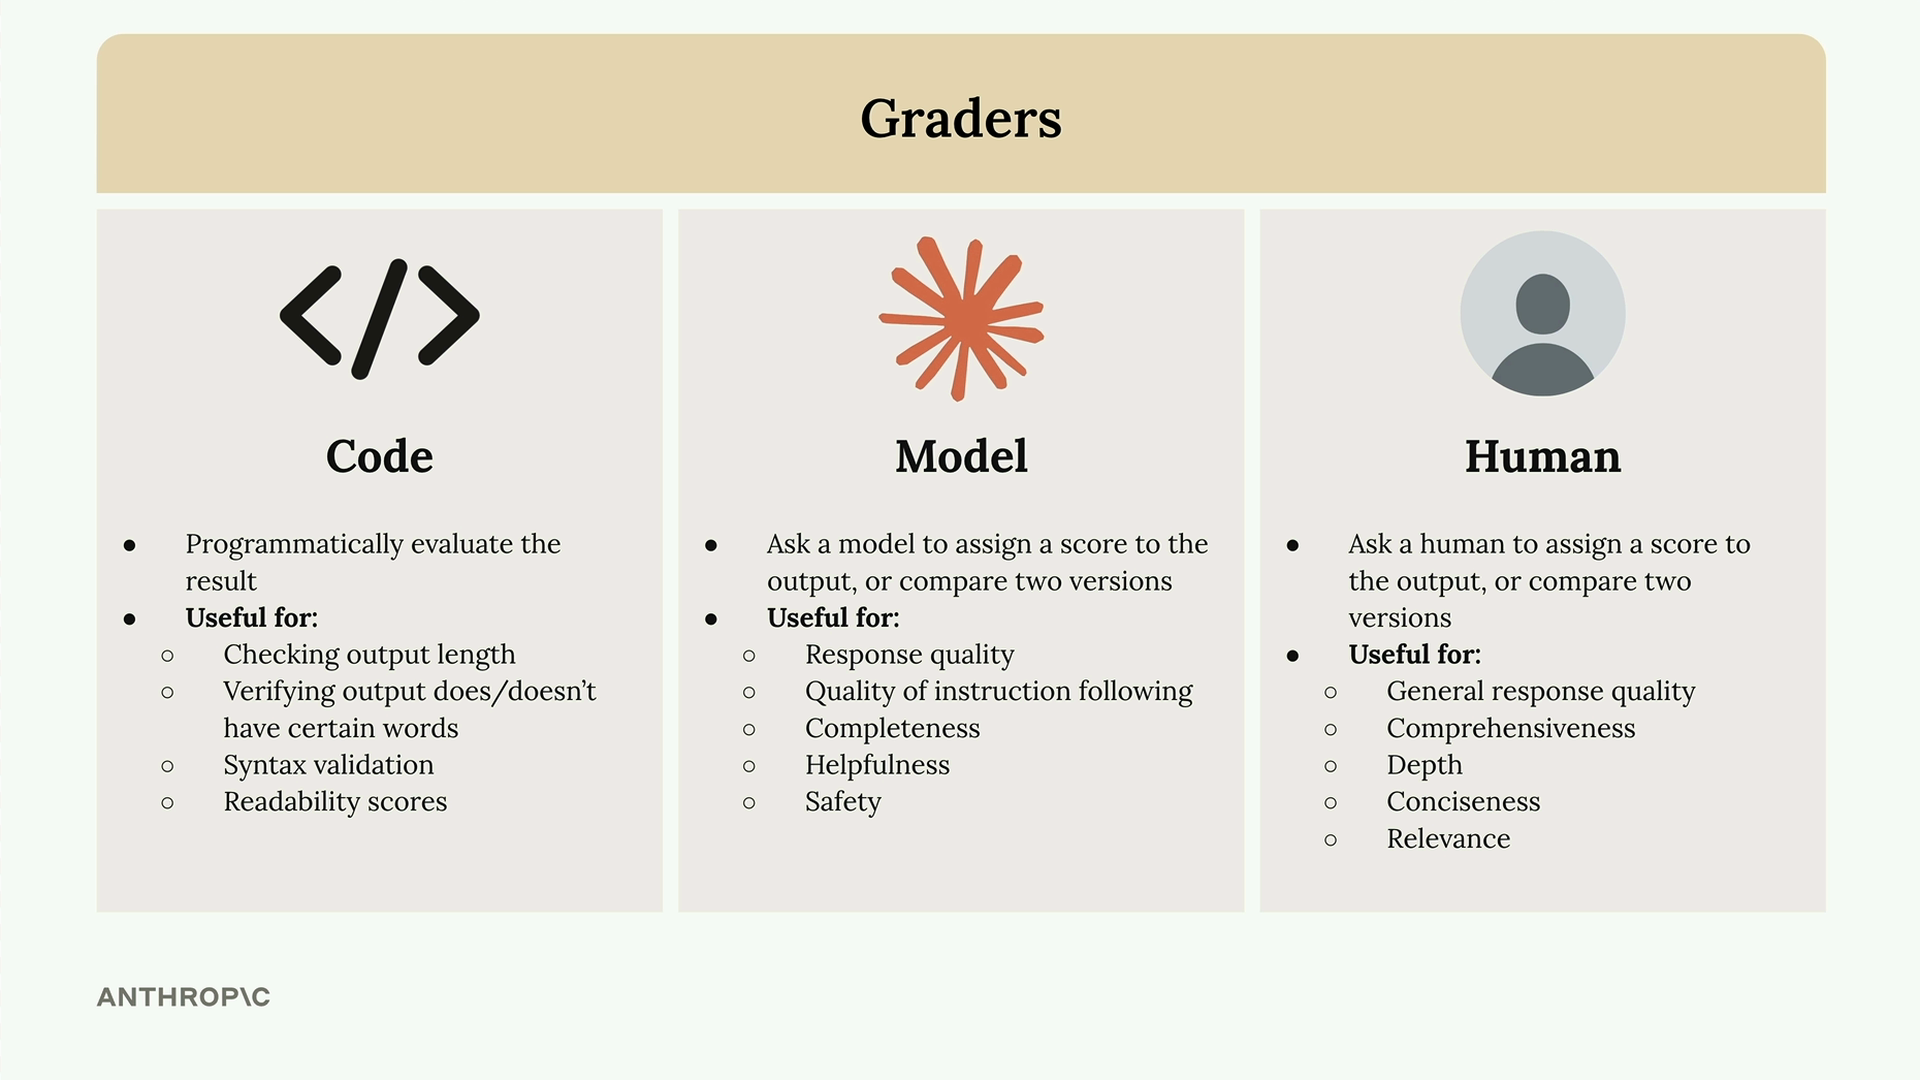

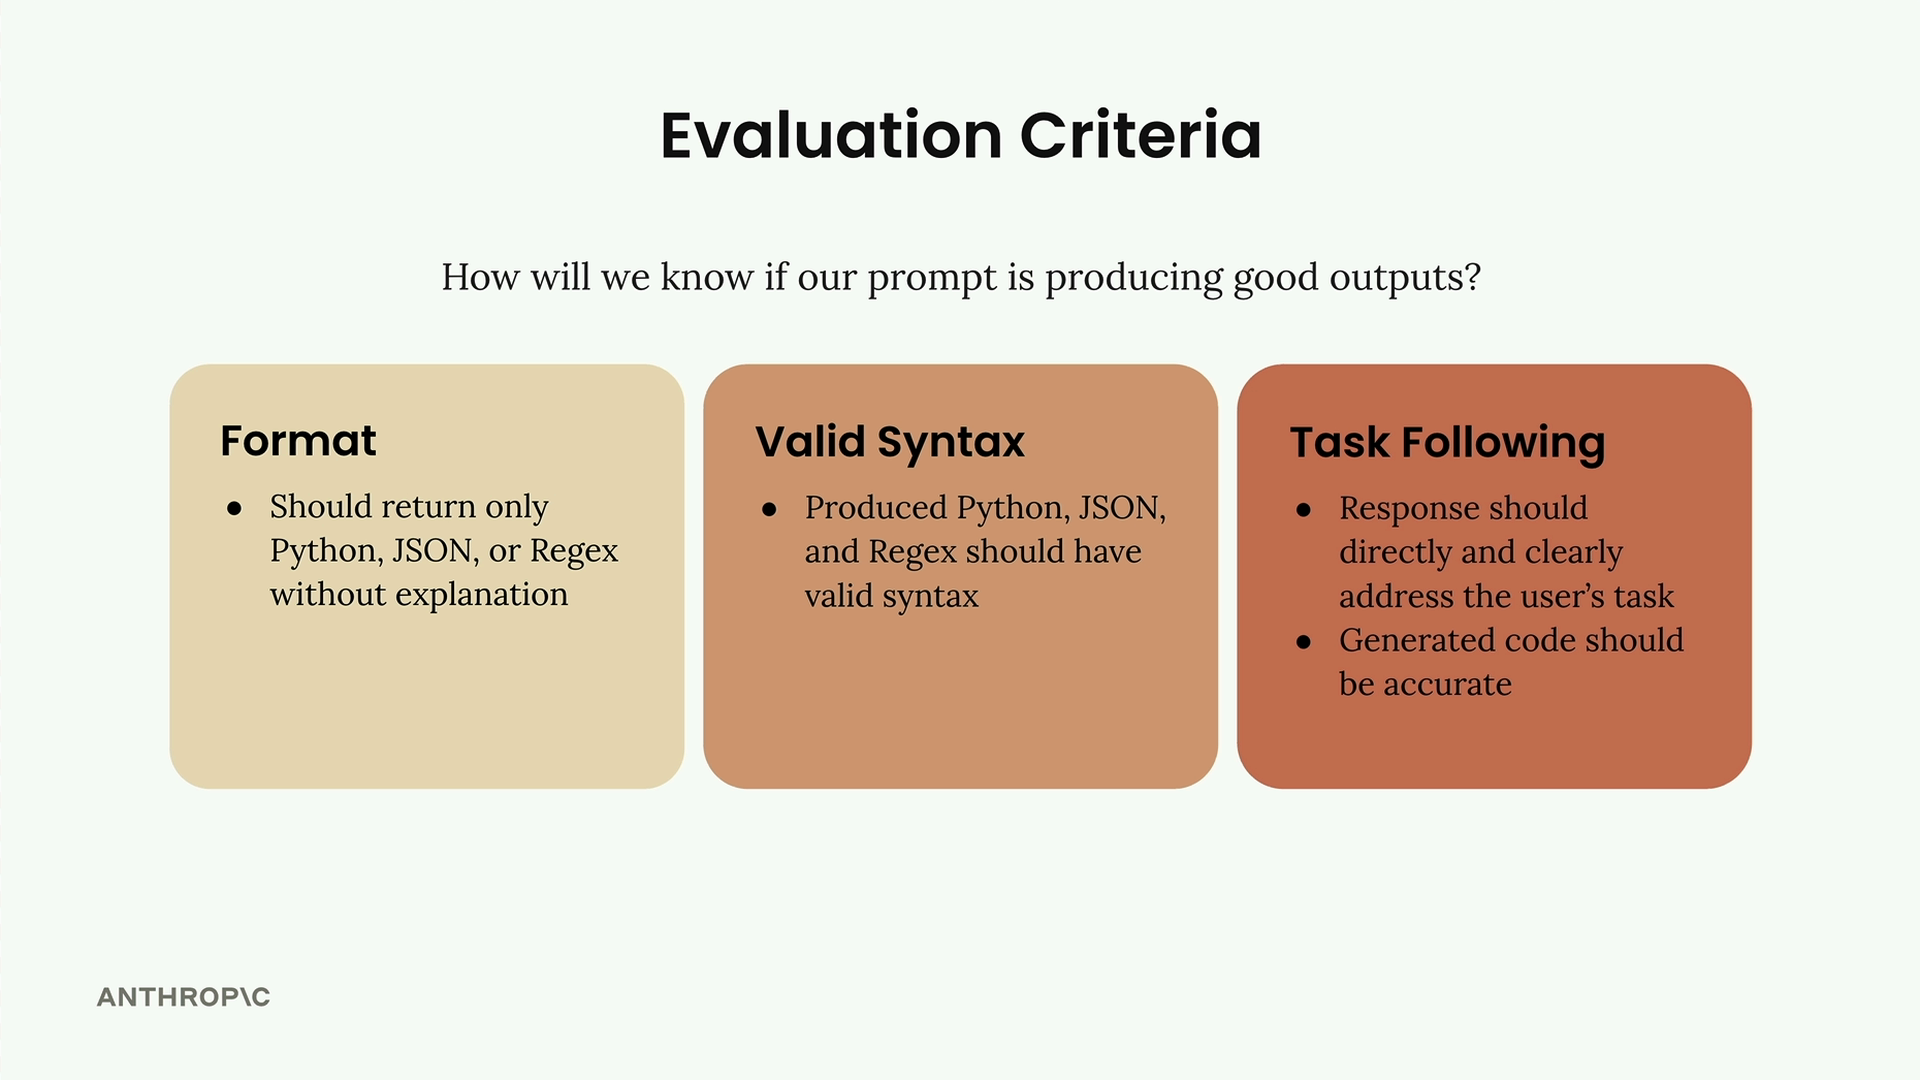

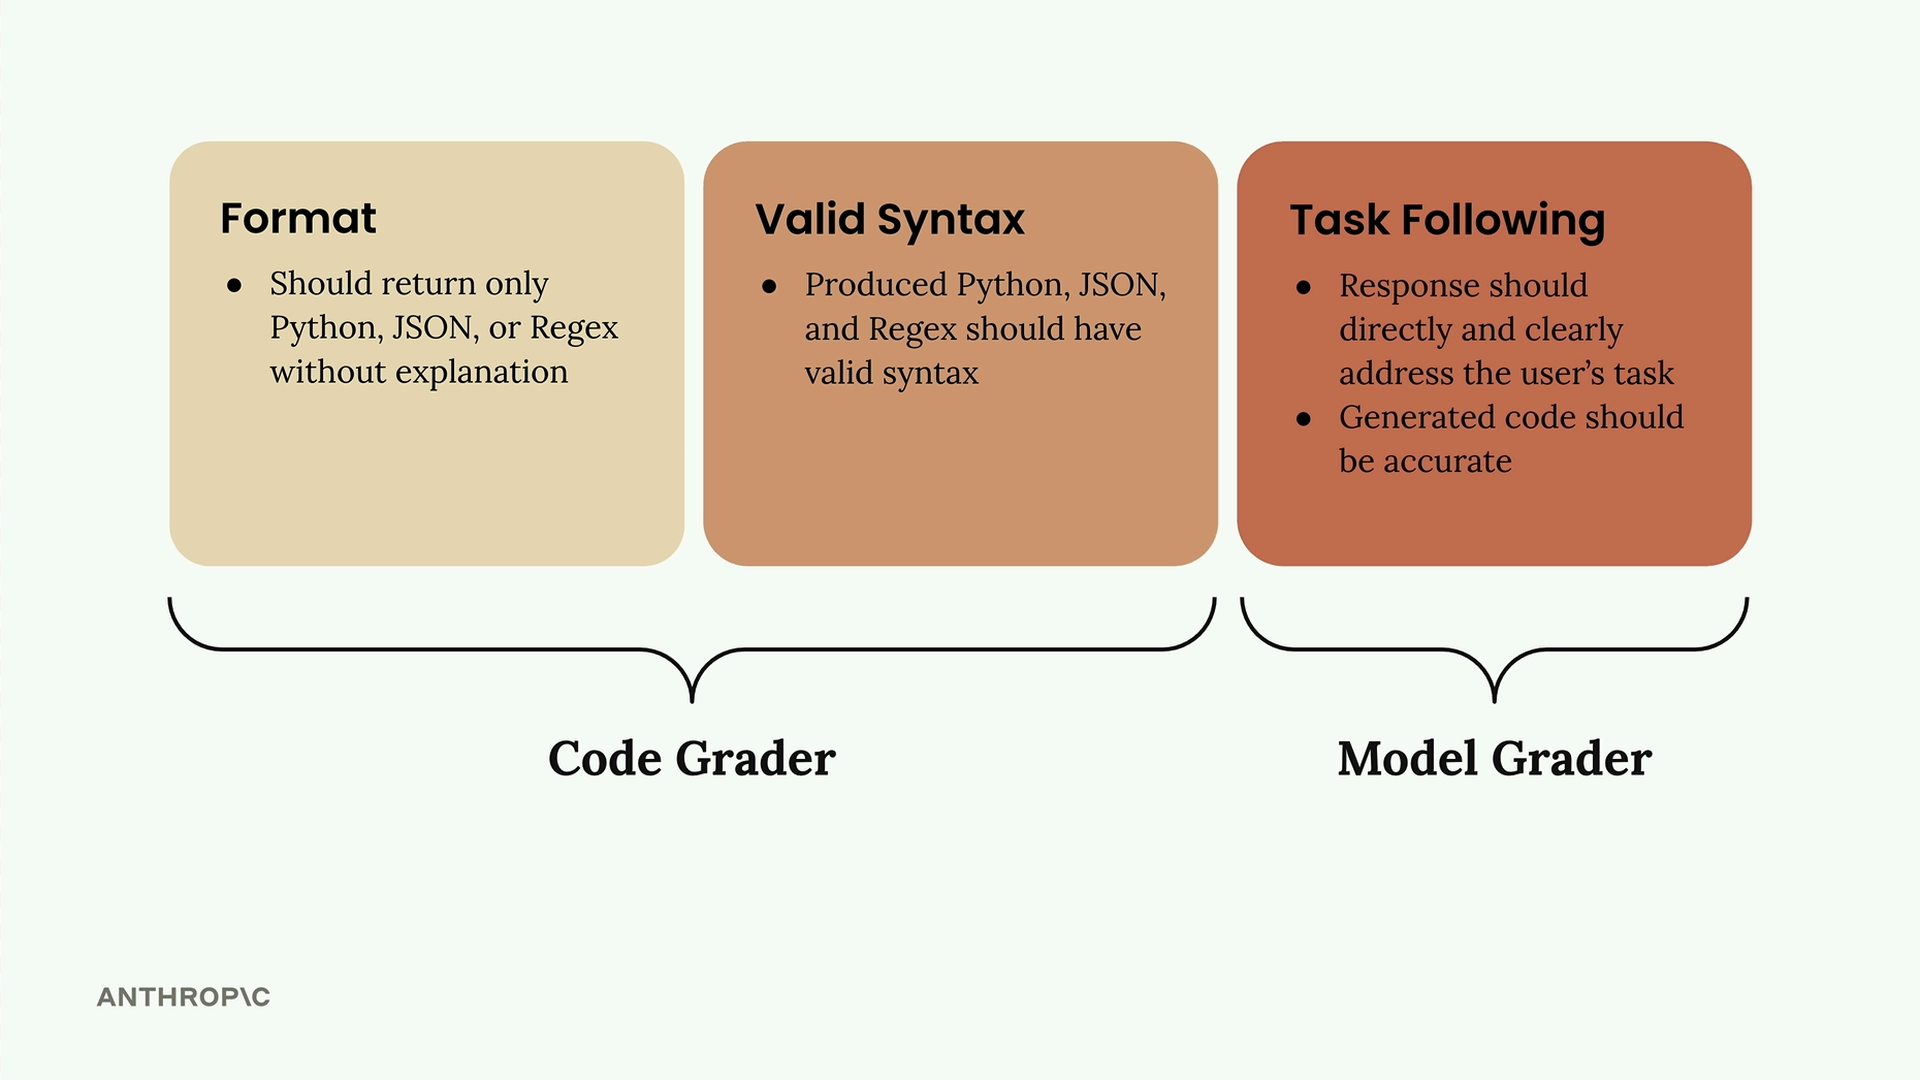